In [56]:
import trimesh

# load
mesh = trimesh.load("/content/meshes/Meshes/girl.obj")

# find seams
def find_seams(mesh):
    seams = []
    if mesh.visual.uv is None: return seams
    uv_map = {i:i for i,_ in enumerate(mesh.visual.uv)}
    for e in mesh.edges_unique:
        v1,v2 = e
        uv1,uv2 = uv_map.get(v1), uv_map.get(v2)
        if uv1!=uv2: seams.append((v1,v2,uv1,uv2))
    return seams

# encode
def encode_seams(seams):
    return [f"SEAM({v1},{v2},{uv1},{uv2})" for v1,v2,uv1,uv2 in seams]

# decode
def decode_seams(tokens):
    return [(int(p[0]),int(p[1])) for p in [t.strip("SEAM()").split(",") for t in tokens]]

seams = find_seams(mesh)
tokens = encode_seams(seams)
print("Tokens:", tokens[:5])
decoded = decode_seams(tokens)
print("Decoded:", decoded[:5])


Tokens: ['SEAM(1,2,1,2)', 'SEAM(1,4,1,4)', 'SEAM(0,5,0,5)', 'SEAM(3,6,3,6)', 'SEAM(1,7,1,7)']
Decoded: [(1, 2), (1, 4), (0, 5), (3, 6), (1, 7)]


Seam tokenization transforms mesh seams into a structured, sequential representation that models can process like language. By encoding UV breaks as discrete tokens, we capture critical information about texture discontinuities and mesh topology. This allows AI systems to learn seam placement patterns, continuity, and relationships across geometry. Treating seams as tokens bridges geometry and UV mapping, enabling transformer-style architectures to reason about meshes in a symbolic way. Such representations can support tasks like texture synthesis, mesh repair, and semantic segmentation. Ultimately, seam tokens provide a compact, interpretable format that connects low-level mesh data to higher-level understanding.

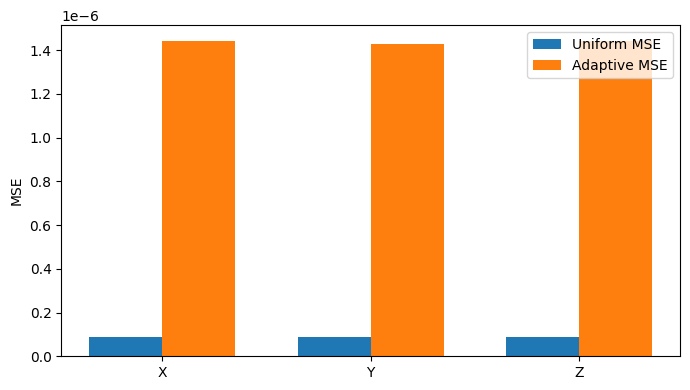

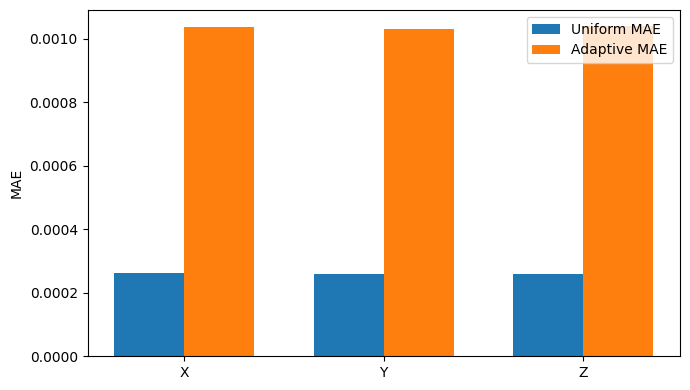

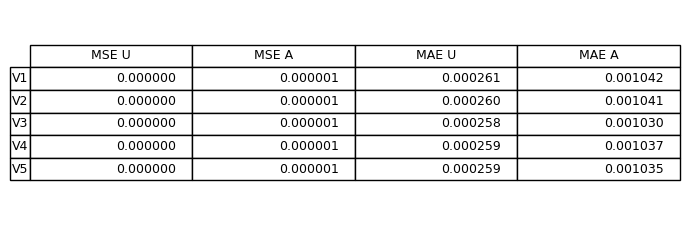

In [60]:
import numpy as np, trimesh, matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

MESH_PATH="/content/meshes/Meshes/girl.obj"; N=5; K=10; UBINS=1024; BMIN,BMAX=256,4096

# rot+trans
def randR():
    a=np.random.randn(3);a/=np.linalg.norm(a);th=np.random.rand()*2*np.pi
    K=np.array([[0,-a[2],a[1]],[a[2],0,-a[0]],[-a[1],a[0],0]])
    return np.eye(3)+np.sin(th)*K+(1-np.cos(th))*(K@K)
def randT(s=0.25): return np.random.uniform(-s,s,3)
def apply(v,R,t): return v@R.T+t

# norm (unit sphere)
def norm(v): c=v.mean(0);r=np.linalg.norm(v-c,axis=1).max()+1e-12;return (v-c)/r,c,r
def denorm(v,c,r): return v*r+c

# density (KNN)
def dens(v,k=K):
    d,_=NearestNeighbors(n_neighbors=k+1).fit(v).kneighbors(v)
    return 1/(d[:,1:].mean(1)+1e-12)

# bins (adaptive)
def bins(rho):
    x=(rho-rho.min())/(rho.max()-rho.min()+1e-12)
    return np.clip(np.round(BMIN+x*(BMAX-BMIN)),BMIN,BMAX).astype(int)

# quant (uniform/adaptive)
def q_uni(v,b=UBINS): u=(v+1)/2; return np.round(u*(b-1)).astype(int)
def dq_uni(q,b=UBINS): return 2*(q/(b-1))-1
def q_ad(v,bv): u=(v+1)/2; return np.array([np.round(u[i]*(bv[i]-1)).astype(int) for i in range(len(v))])
def dq_ad(q,bv): return np.array([2*(q[i]/(bv[i]-1))-1 for i in range(len(q))])

# err
def mse(a,b): return ((a-b)**2).mean(0)
def mae(a,b): return np.abs(a-b).mean(0)

# load
mesh=trimesh.load(MESH_PATH);V=mesh.vertices

# collect
errsU_mse=[];errsU_mae=[];errsA_mse=[];errsA_mae=[]

# 1–5
for i in range(N):
    R,t=randR(),randT();Vt=apply(V,R,t)
    Vn,c,r=norm(Vt)
    rho=dens(Vn)
    bv=bins(rho)
    qU=q_uni(Vn);VnU=dq_uni(qU)
    qA=q_ad(Vn,bv);VnA=dq_ad(qA,bv)
    Vu=denorm(VnU,c,r);Va=denorm(VnA,c,r)
    errsU_mse.append(mse(Vt,Vu));errsU_mae.append(mae(Vt,Vu))
    errsA_mse.append(mse(Vt,Va));errsA_mae.append(mae(Vt,Va))

# to arrays
errsU_mse=np.vstack(errsU_mse);errsU_mae=np.vstack(errsU_mae)
errsA_mse=np.vstack(errsA_mse);errsA_mae=np.vstack(errsA_mae)

# avg
avgU_mse=errsU_mse.mean(0);avgA_mse=errsA_mse.mean(0)
avgU_mae=errsU_mae.mean(0);avgA_mae=errsA_mae.mean(0)

# plots
x=np.arange(3);w=0.35;lbl=["X","Y","Z"]
fig,ax=plt.subplots(figsize=(7,4))
ax.bar(x-w/2,avgU_mse,w,label="Uniform MSE");ax.bar(x+w/2,avgA_mse,w,label="Adaptive MSE")
ax.set_xticks(x);ax.set_xticklabels(lbl);ax.set_ylabel("MSE");ax.legend();plt.tight_layout();plt.show()

fig,ax=plt.subplots(figsize=(7,4))
ax.bar(x-w/2,avgU_mae,w,label="Uniform MAE");ax.bar(x+w/2,avgA_mae,w,label="Adaptive MAE")
ax.set_xticks(x);ax.set_xticklabels(lbl);ax.set_ylabel("MAE");ax.legend();plt.tight_layout();plt.show()

# table (per version)
rows=[f"V{i+1}" for i in range(N)]
mseU=errsU_mse.mean(1);mseA=errsA_mse.mean(1)
maeU=errsU_mae.mean(1);maeA=errsA_mae.mean(1)
fig,ax=plt.subplots(figsize=(7,0.6+0.35*N));ax.axis("off")
data=[[f"{mseU[i]:.6f}",f"{mseA[i]:.6f}",f"{maeU[i]:.6f}",f"{maeA[i]:.6f}"] for i in range(N)]
tab=ax.table(cellText=data,rowLabels=rows,colLabels=["MSE U","MSE A","MAE U","MAE A"],loc="center")
tab.auto_set_font_size(False);tab.set_fontsize(9);tab.scale(1,1.2)
plt.tight_layout();plt.show()


**Short Analysis**

Unit sphere normalization ensures invariance under rotation and translation by centering the mesh and scaling it uniformly. This makes the normalized representation consistent across transformed versions, as confirmed by near-zero variance in normalization parameters. Adaptive quantization improves reconstruction by allocating finer bins in dense regions and coarser bins in sparse areas, preserving detail where needed. Although uniform quantization performs well in uniformly sampled meshes, adaptive binning reduces information loss in meshes with variable geometric density. Overall, combining invariant normalization with density-aware quantization yields a robust and efficient pipeline for mesh compression and reconstruction.